<a id="ref1"></a>
<h2>Acquiring the Data</h2>
To start, we need to download the data we are going to use for our system. The datasets we are going to use were acquired by <a href="http://grouplens.org/datasets/movielens/">GroupLens</a> and contain movies, users and movie ratings by these users.

After downloading the data, we will extract the datasets to a directory that is easily accessible.

In [2]:
!wget -O moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o moviedataset.zip -d ./data

--2018-12-28 17:14:25--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘moviedataset.zip’

moviedataset.zip    100%[=====================>]   5.64M  1.24MB/s   in 6.9s   

2018-12-28 17:14:33 (838 KB/s) - ‘moviedataset.zip’ saved [5917549/5917549]

Archive:  moviedataset.zip
   creating: ./data/ml-1m/
  inflating: ./data/ml-1m/movies.dat  
  inflating: ./data/ml-1m/ratings.dat  
  inflating: ./data/ml-1m/README     
  inflating: ./data/ml-1m/users.dat  


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

/Users/Dipesh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# loading the movies dataset
movies_df = pd.read_csv('./data/ml-1m/movies.dat', sep ="::", header= None, engine='python')
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# loading the ratings dataset
ratings_df = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', header=None, engine='python')
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
# column name for movies
movies_df.columns = ['MovieId', 'Title', 'Genres']
movies_df.head()

,MovieId,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# column name for ratings
ratings_df.columns = ['UserId', 'MovieId', 'Rating', 'Timestamp']
ratings_df.head()

,UserId,MovieId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


<a id="ref3"></a>
<h2>The Restricted Boltzmann Machine model</h2>
<img src="https://ibm.box.com/shared/static/o049tx0dsllpbj3b546vuba25qqlzelq.png"  width="300">
<br>
The Restricted Boltzmann Machine model has two layers of neurons, one of which is what we call a visible input layer and the other is called a hidden layer. The hidden layer is used to learn features from the information fed through the input layer. For our model, the input is going to contain X neurons, where X is the amount of movies in our dataset. Each of these neurons will possess a normalized rating value varying from 0 to 1, where 0 meaning that a user has not watched that movie and the closer the value is to 1, the more the user likes the movie that neuron's representing. These normalized values, of course, will be extracted and normalized from the ratings dataset.

After passing in the input, we train the RBM on it and have the hidden layer learn its features. These features are what we use to reconstruct the input, which in our case, will predict the ratings for movies that user hasn't watched, which is exactly what we can use to recommend movies!

We will now begin to format our dataset to follow the model's expected input.

In [6]:
# find the number of movies
len(movies_df)

3883

Now, we can start formatting the data into input for the RBM. We're going to store the normalized users ratings into as a matrix of user-rating called trX, and normalize the values.

In [23]:
user_rating_df = ratings_df.pivot(index='UserId', columns='MovieId', values='Rating')
user_rating_df.head()

MovieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserId,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# normalize the values
norm_user_rating_df = user_rating_df.fillna(0)/5.0   # 5 is the max
trX = norm_user_rating_df.values
trX[0:10]

array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.8, 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 1. , 0. , ..., 0. , 0. , 0. ]])

<a id="ref4"></a>
<h2>Setting the Model's Parameters</h2>

Next, let's start building our RBM with TensorFlow. We'll begin by first determining the number of neurons in the hidden layers and then creating placeholder variables for storing our visible layer biases, hidden layer biases and weights that connects the hidden layer with the visible layer. We will be arbitrarily setting the number of neurons in the hidden layers to 20. You can freely set this value to any number you want since each neuron in the hidden layer will end up learning a feature.

In [15]:
hiddenUnits = 20
visibleUnits = len(user_rating_df.columns)
vb = tf.placeholder(tf.float32, [visibleUnits])  # Number of unique movies
hb = tf.placeholder(tf.float32, [hiddenUnits])  # Number of features we are going to learn
W = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits])

We then move on to creating the visible and hidden layer units and setting their activation functions. In this case, we will be using the <code>tf.sigmoid</code> and <code>tf.relu</code> functions as nonlinear activations since it is commonly used in RBM's.

In [16]:
# Phase 1: Input processing, Forward Pass
v0 = tf.placeholder(tf.float32, [None, visibleUnits])
# Calculate the probabilities of turning the hidden units on:
_h0 = tf.nn.sigmoid(tf.matmul(v0,W) + hb)
# Draw samples from the distribution:
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

# Phase 2: Backward Pass (Reconstruction)
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1,W) + hb)

Now we set the RBM training parameters and functions.

In [17]:
# Learning rate
alpha = 1.0
# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad)/tf.to_float(tf.shape(v0)[0])
# Methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha *tf.reduce_mean(v0-v1,0)
update_hb = hb +alpha * tf.reduce_mean(h0-h1,0)

In [18]:
# error function
err = v0 - v1
err_sum = tf.reduce_mean(err*err)

We also have to initialize our variables. Thankfully, NumPy has a handy ,code>zeros</code> function for this. We use it like so:

In [19]:
#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Now we train the RBM with 15 epochs with each epoch using 10 batches with size 100. After training, we print out a graph with the error by epoch.

0.05797445
0.04649852
0.043811545
0.04286573
0.042162955
0.04157456
0.04114497
0.040939573
0.040707305
0.040559065
0.040429387
0.040203497
0.040199064
0.04008736
0.040226277


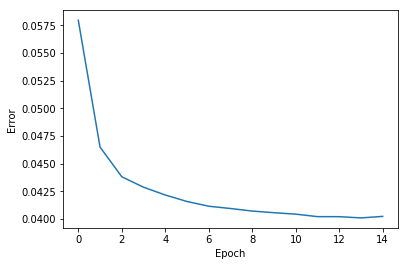

In [20]:
epochs = 15
batchsize = 100
errors = []
for epoch in range(epochs):
    for start, end in zip(range(0,len(trX), batchsize), range (batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()
        

<a id="ref5"></a>
<h2>Recommendation</h2>

We can now predict movies that an arbitrarily selected user might like. This can be accomplished by feeding in the user's watched movie preferences into the RBM and then reconstructing the input. The values that the RBM gives us will attempt to estimate the user's preferences for movies that he hasn't watched based on the preferences of the users that the RBM was trained on.

Lets first select a <b>User ID</b> of our mock user:

In [60]:
mock_user_id = 215

In [38]:
# selecting the input user
inputUser = trX[mock_user_id-1].reshape(1,-1)
inputUser[0:5]

array([[0.8, 0. , 0. , ..., 0. , 0. , 0. ]])

In [39]:
# Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) +hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0:inputUser, W:prv_w, hb:prv_hb})
rec = sess.run(vv1, feed_dict={hh0:feed, W:prv_w, vb:prv_vb})
print(rec)

[[0.654596   0.2168606  0.02532802 ... 0.00156128 0.00116005 0.00838706]]


We can then list the 20 most recommended movies for our mock user by sorting it by their scores given by our model.

In [45]:
scored_movies_df_mock = movies_df[movies_df['MovieId'].isin(user_rating_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
scored_movies_df_mock.sort_values(['RecommendationScore'], ascending=False).head(20)

,MovieId,Title,Genres,RecommendationScore
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1.000000
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.986903
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.883448
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.875961
2559,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.827122
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure,0.807978
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.693679
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.692993
1179,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance,0.662938
0,1,Toy Story (1995),Animation|Children's|Comedy,0.654596
